# EEG Signal Preprocessing Notebook

## 1️⃣ Import Libraries & Set Paths
- Import Python packages: `numpy`, `pandas`, `matplotlib`, `scipy.signal`, `os`, `re`, `pathlib`
- Set raw data directory path
- Optional: set random seed for reproducibility

---

## 2️⃣ Understand Dataset
- Data format: `sXX_exXX_sXX.txt`
  - `s` = subject number  
  - `ex` = experiment number  
  - `s` = session number (only for ex01/ex02)  
- 4 EEG channels: **T7, F8, Cz, P4**  
- Sampling rate: **200 Hz**  
- Electrodes: **Gold Cup with Ten20 conductive paste**  
- Check for header row (`Sample, T7, F8, Cz, P4`)  
- Plan how to handle headers when loading the file

---

## 3️⃣ Load EEG Data
- Function to read any EEG file:
  - Skip headers or non-numeric columns
  - Return `sample_idx` (column 0) and `eeg_data` (columns 1–4)
- Ensure flexibility to load files from any experiment

---

## 4️⃣ Initial Visualization
- Plot raw EEG signals
  - Stack channels with offsets
  - Optionally plot individual channels
- Observe noise, artifacts, offsets, and amplitude differences

---

## 5️⃣ Signal Preprocessing
Raw EEG
 ↓
Bandpass Filter (0.5–40 Hz)
 ↓
Amplification (gain = 5–20)
 ↓
Re-reference (average)
 ↓
ICA Artifact Removal
 ↓
Epoching (stimulus-locked)
 ↓
ERP / FFT / Wavelets
 ↓
Feature Selection
 ↓
Machine Learning
 ↓
Interpretation & Visualization

**5a. Offset / Detrend (Optional)**  
- Remove DC offset or baseline drift if needed  

**5b. Bandpass Filtering**  
- Apply **Butterworth 1–40 Hz filter**  
- Use `filtfilt` for zero-phase distortion  

**5c. Optional Notch Filter**  
- Remove **50 Hz line noise** if present  

---

## 6️⃣ Artifact Handling
- Identify/remove spikes or unusual peaks
- Optional: simulate motion artifacts for modeling

---

## 7️⃣ Feature Extraction
- **Time-domain features:** RMS, Peak-to-Peak, Mean, Std  
- **Frequency-domain features:** FFT, band power (delta, theta, alpha, beta)

---

## 8️⃣ Parameter Sweep / System Modeling
- Add Gaussian noise at varying levels
- Adjust filter cutoffs and observe effects on signal quality
- Visualize impact across channels

---

## 9️⃣ Save Preprocessed Data
- Save filtered EEG arrays for future analysis
- Maintain folder structure:
  - `raw/`  
  - `filtered/`  
  - `segmented/` (if applicable)

---

## Notes / References
- Jurcak V, Tsuzuki D, Dan I. 10/20, 10/10, and 10/5 systems revisited: their validity as relative head-surface-based positioning systems. Neuroimage. 2007 Feb 15;34(4):1600-11.
Altahat SH. Robust EEG Channel Set for Biometric Application (Doctoral dissertation, University of Canberra).
Ravi KV, Palaniappan R. A minimal channel set for individual identification with EEG biometric using genetic algorithm. InInternational Conference on Computational Intelligence and Multimedia Applications (ICCIMA 2007) 2007 Dec 13 (Vol. 2, pp. 328-332). IEEE.
Marcel S, Millán JD. Person authentication using brainwaves (EEG) and maximum a posteriori model adaptation. IEEE transactions on pattern analysis and machine intelligence. 2007 Feb 20;29(4):743-52.
World Medical Association. World Medical Association Declaration of Helsinki. Ethical principles for medical research involving human subjects. Bulletin of the World Health Organization. 2001;79(4):373.


## 1️⃣ Import Libraries and Set Paths

In [24]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
import pandas as pd

## 5️⃣ Signal Pre-processing

Its clear that the raw data has noise. We can intoduce a bandpass filter to remove low frequencies and very high frequencies. 

In [25]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
from pathlib import Path
import matplotlib.pyplot as plt

# =========================================
# Constants 
# =========================================
FS = 200  # Sampling rate in Hz
CANONICAL_CHANNELS = ['T7', 'F8', 'Cz', 'P4']  # EEG channels
SCALE_FACTOR = 15686 / 8388607  # µV per LSB (Ganglion ADC)

# =========================================
# Paths to data
# =========================================
raw_dir = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/Raw_Data")  # Raw EEG Signal
trim_file = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/data_trim.csv")  # Trim points
filtered_dir = Path("data/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/Filtered_Data")  # Reference data

# =========================================
# Trim Utilities
# =========================================
def load_trim_file(trim_file):
    """Load and validate data_trim.csv"""
    trim_df = pd.read_csv(trim_file)
    expected_cols = {'Subject', 'Experment', 'session', 'From (n)', 'To (n)'}
    missing = expected_cols - set(trim_df.columns)
    if missing:
        raise ValueError(f"Missing columns in data_trim.csv: {missing}")
    return trim_df

def get_trim_indices(trim_df, subject, experiment, session):
    """Return start/end sample indices from data_trim.csv"""
    row = trim_df[
        (trim_df['Subject'] == subject) &
        (trim_df['Experment'] == experiment) &
        (trim_df['session'] == session)
    ]
    if row.empty:
        raise ValueError(f"No trim info for Subject {subject}, Experiment {experiment}, Session {session}")
    start_sample = int(row['From (n)'].values[0])
    end_sample = int(row['To (n)'].values[0])
    return start_sample, end_sample

# =========================================
# Preprocessing
# =========================================
def remove_dc_offset(eeg):
    """Remove DC offset (zero-mean per channel)"""
    return eeg - np.mean(eeg, axis=0, keepdims=True)

def bandpass_1_40hz(eeg, fs=FS):
    """1st-order Butterworth bandpass 1-40 Hz"""
    low, high = 1, 40
    b, a = butter(N=1, Wn=[low/(fs/2), high/(fs/2)], btype='band')
    return filtfilt(b, a, eeg, axis=0)

def notch_50hz(eeg, fs=FS):
    """50 Hz notch filter with Q=30"""
    f0 = 50
    Q = 30
    b, a = iirnotch(f0/(fs/2), Q)
    return filtfilt(b, a, eeg, axis=0)

def preprocess_eeg(eeg):
    """Apply bandpass + notch filtering"""
    eeg = bandpass_1_40hz(eeg)
    eeg = notch_50hz(eeg)    
    return eeg

def rereference_average(eeg):
    """Average reference across channels. Removes channel biases."""
    return eeg - np.mean(eeg, axis=1, keepdims=True)

# =========================================
# Gain Matching
# =========================================
def match_reference_gain(my_eeg, ref_eeg, method="max"):
    """
    Match amplitude of my EEG to reference EEG.

    Parameters
    ----------
    my_eeg : np.ndarray
        Preprocessed EEG (n_samples x n_channels)
    ref_eeg : np.ndarray
        Reference EEG (n_samples x n_channels)
    method : str
        'max'  -> match max absolute amplitude
        'rms'  -> match RMS energy

    Returns
    -------
    scaled_eeg : np.ndarray
    gain : float
        Applied gain factor
    """
    if method == "max":
        my_amp = np.max(np.abs(my_eeg), axis=0)
        ref_amp = np.max(np.abs(ref_eeg), axis=0)
    elif method == "rms":
        my_amp = np.sqrt(np.mean(my_eeg**2, axis=0))
        ref_amp = np.sqrt(np.mean(ref_eeg**2, axis=0))
    else:
        raise ValueError("method must be 'max' or 'rms'")

    if np.any(my_amp == 0):
        raise ValueError("My EEG amplitude is zero in one or more channels, cannot compute gain.")
    
    gain = ref_amp / my_amp
    return my_eeg * gain, gain

# =========================================
# Load EEG
# =========================================
def load_and_preprocess_eeg(
        raw_file, trim_df, subject, 
        experiment, session, 
        reference_file=None, 
        apply_gain_match=False, 
        gain_method="rms",
        apply_avg_ref=False
    ):
    """
    Load raw EEG file and preprocess to match PhysioNet Filtered_Data.
    
    Returns:
    - sample_idx: np.ndarray of sample indices
    - eeg: np.ndarray of preprocessed EEG (n_samples x 4 channels)
    """
    # Load raw file
    df = pd.read_csv(raw_file)
    df.columns = df.columns.str.strip()

    # Map ADC channels to canonical names
    raw_channel_map = {
        'EXG Channel 0':'T7', 
        'EXG Channel 1':'F8', 
        'EXG Channel 2':'Cz', 
        'EXG Channel 3':'P4'
    }
    df = df.rename(columns=raw_channel_map)

    # Check channels
    missing = set(CANONICAL_CHANNELS) - set(df.columns)
    if missing:
        raise ValueError(f"Missing channels in raw file: {missing}")

    # Extract sample indices and EEG
    sample_idx = df.iloc[:, 0].to_numpy()
    eeg = df[CANONICAL_CHANNELS].to_numpy()

    # --- Scale ADC → µV ---
    eeg = eeg * SCALE_FACTOR

    # --- Remove DC offset and apply Filters---
    eeg = remove_dc_offset(eeg)
    eeg = preprocess_eeg(eeg)

    # Average reference
    if apply_avg_ref: 
        eeg = rereference_average(eeg)

    # --- Trim to clean 2-minute segment ---
    start, end = get_trim_indices(trim_df, subject, experiment, session)
    sample_idx = sample_idx[start:end]
    eeg = eeg[start:end, :]
    
    # --- Perform Gain Match ---
    if apply_gain_match: 
        if reference_file is None:
            raise ValueError("reference_file must be provided for gain matching.")
        
        ref = load_filtered_reference(reference_file)
        ref = ref[:len(eeg)] # align length

        eeg, gain = match_reference_gain(eeg, ref, method=gain_method)
    return sample_idx, eeg

# =========================================
# Load Filtered Reference
# =========================================
def load_filtered_reference(file_path):
    """Load PhysioNet filtered EEG in canonical channel order."""
    df = pd.read_csv(file_path)
    missing = set(CANONICAL_CHANNELS) - set(df.columns)
    if missing:
        raise ValueError(f"Missing channels in filtered file: {missing}")
    return df[CANONICAL_CHANNELS].to_numpy()

# =========================================
# Plotting
# =========================================
def plot_eeg_signal(eeg, channel=0, window=None):
    """Plot a single EEG channel by itself"""
    ch_name = CANONICAL_CHANNELS[channel]
    signal = eeg[:, channel]
    if window is not None:
        signal = signal[:window]
    plt.figure(figsize=(12,4))
    plt.plot(signal, label=ch_name, color='tab:blue')
    plt.title(f"EEG Signal: {ch_name}")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (µV)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def compare_with_reference(eeg, reference_file, channel=0, window=None, show_diff=True, show_corr=True, offset_gap=50):
    """Compare preprocessed EEG vs PhysioNet reference with vertical offset"""
    df_ref = pd.read_csv(reference_file)
    ch_name = CANONICAL_CHANNELS[channel]

    ref = df_ref[ch_name].to_numpy()
    my = eeg[:, channel]

    # Zoom window if requested
    if window is not None:
        my = my[:window]
        ref = ref[:window]

    n = min(len(my), len(ref))
    my = my[:n]
    ref = ref[:n]

    # Apply vertical offset for plotting
    my_offset = my + offset_gap

    plt.figure(figsize=(12,4))
    plt.plot(my_offset, label=f"My Ch {ch_name} + {offset_gap} uV", alpha=0.7)
    plt.plot(ref, label=f"Ref Ch {ch_name} uV", alpha=0.7)
    plt.title(f"{ch_name} Comparison")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (µV)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if show_diff:
        diff = my - ref
        plt.figure(figsize=(12,4))
        plt.plot(diff)
        plt.title(f"Difference: {ch_name} (My − Ref)")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude Difference (µV)")
        plt.tight_layout()
        plt.show()
        print(f"{ch_name} max diff: {np.max(np.abs(diff)):.5f} µV | mean diff: {np.mean(diff):.5f} µV")

    if show_corr:
        corr = np.corrcoef(my, ref)[0,1]
        print(f"{ch_name} correlation: {corr:.6f}")


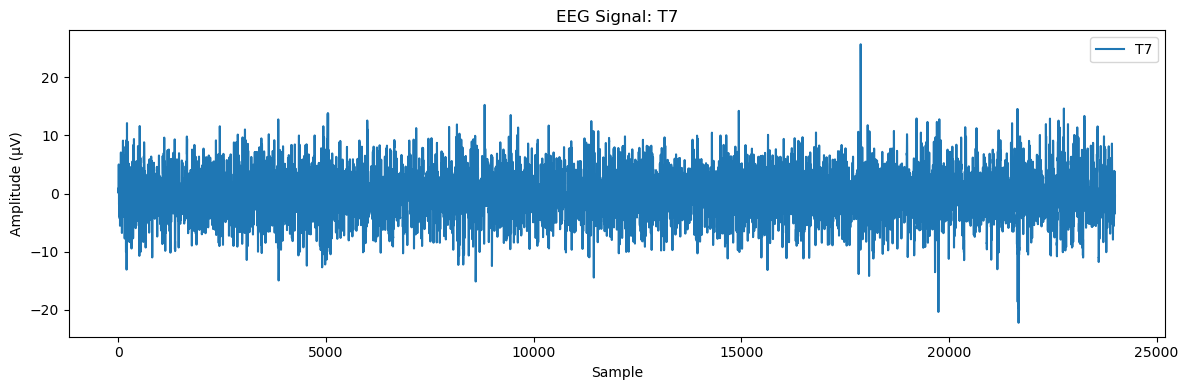

In [26]:
# Preprocess raw EEG like PhysioNet
trim_df = load_trim_file(trim_file)

subject = 1
experiment = 1   # numeric, as in data_trim.csv
session = 1

raw_file = raw_dir / "ex01" / "s01_ex01_s01.txt"
ref_file = filtered_dir / "s01_ex01_s01.csv"

sample_idx, eeg_proc = load_and_preprocess_eeg(
    raw_file, 
    trim_df, 
    subject=subject, 
    experiment=experiment, 
    session=session, 
    reference_file=ref_file,
    apply_gain_match=True,
    gain_method="rms",
)

# Plot T7
plot_eeg_signal(eeg_proc, channel=0)


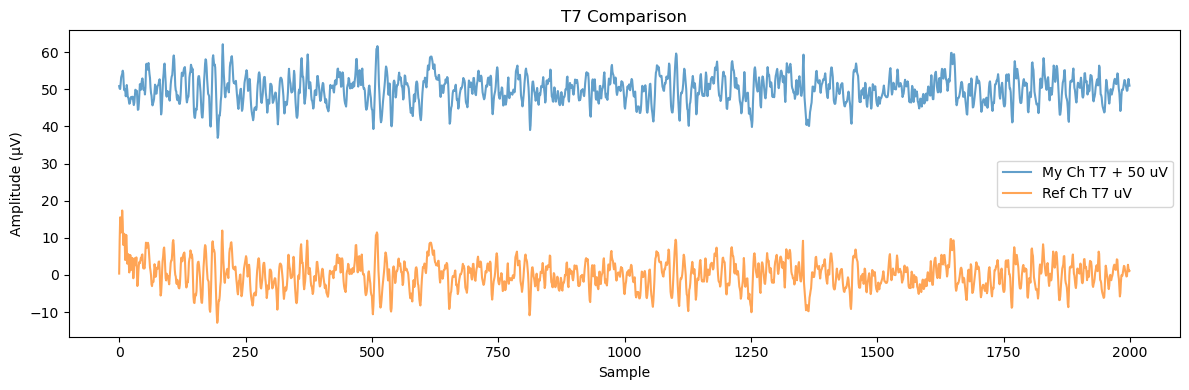

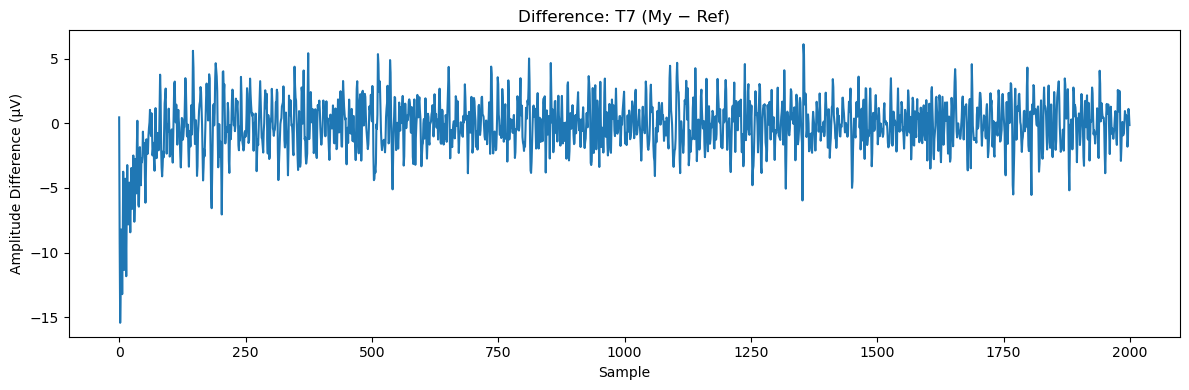

T7 max diff: 15.44228 µV | mean diff: -0.17906 µV
T7 correlation: 0.854020


In [27]:
compare_with_reference(
    eeg_proc,
    reference_file=ref_file,
    channel=0,       # T7
    window=10 * FS,   # 5 seconds
    show_diff=True,
    show_corr=True,
    offset_gap=50
)

In [28]:
# The amplification is not listed in the README, but we can deduce it by comparing the mean absolute values
ref = load_filtered_reference(ref_file)
my_max = np.max(np.abs(eeg_proc))
ref_max = np.max(np.abs(ref))
print(f"My EEG max: {my_max:.3f} µV | Reference max: {ref_max:.3f} µV")
print(f"Scale factor: {ref_max/my_max:.3f}")

My EEG max: 81.141 µV | Reference max: 80.805 µV
Scale factor: 0.996


The Pre-processing steps have been deduced to be as  for the Physionet dataset: 

Raw EEG
 ↓
Bandpass Filter (0.5–40 Hz)
 ↓
Amplification (gain = 5–20)

There is a suggested pipeline for [EEG pre-processing] (https://www.frontiersin.org/journals/neuroinformatics/articles/10.3389/fninf.2015.00016/full):
1. Apply Filters
2. Re-reference
3. Reject Artifacts
4. Select Window Sizes 
5. Frequency Domain Decomposition
6. Average

The study has already done filter application with a Bandpass and Notch filter. They selected trim points that have minimal noise during the performed events. These steps are steps 1 and 4.
We can take it further by implementing [re-referencing](https://imotions.com/blog/learning/best-practice/5-basics-eeg-data-processing/?srsltid=AfmBOoqHSEz2famWQu7eTFKx9c_wEfE6Z5pOQJjwFvYxDWwTfthvUtUP) which helps in removing bad channel noises affecting the other channels. This in other words removes channel contamination the reference electrode could have experienced.


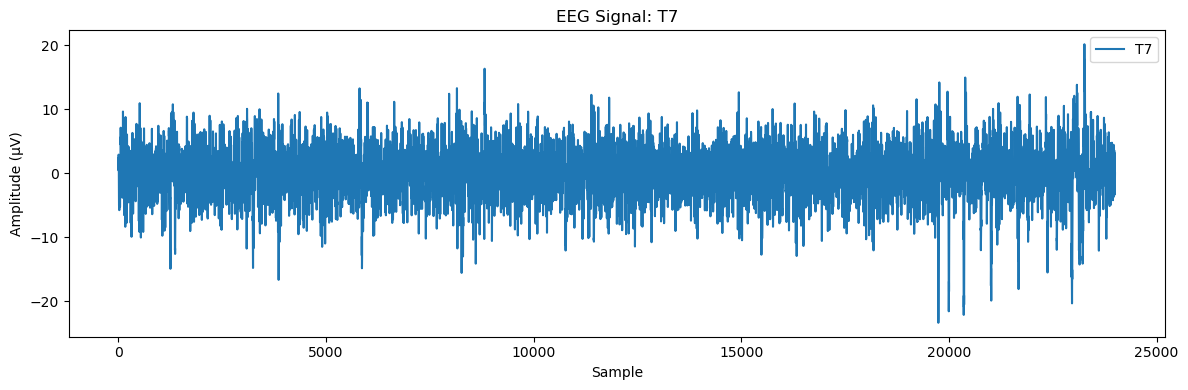

In [20]:
# Apply re-reference average
sample_idx, eeg_proc = load_and_preprocess_eeg(
    raw_file, 
    trim_df, 
    subject=subject, 
    experiment=experiment, 
    session=session, 
    reference_file=ref_file,
    apply_gain_match=True,
    gain_method="rms",
    apply_avg_ref=True
)

# Plot T7
plot_eeg_signal(eeg_proc, channel=0)

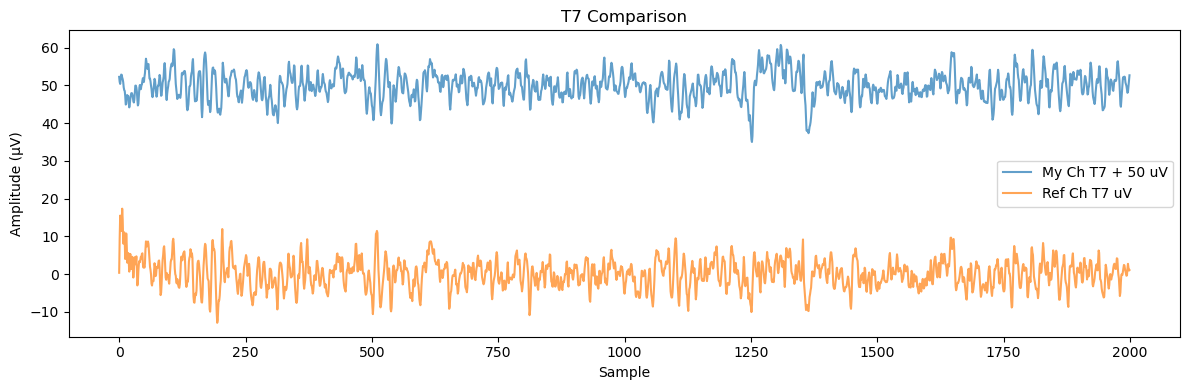

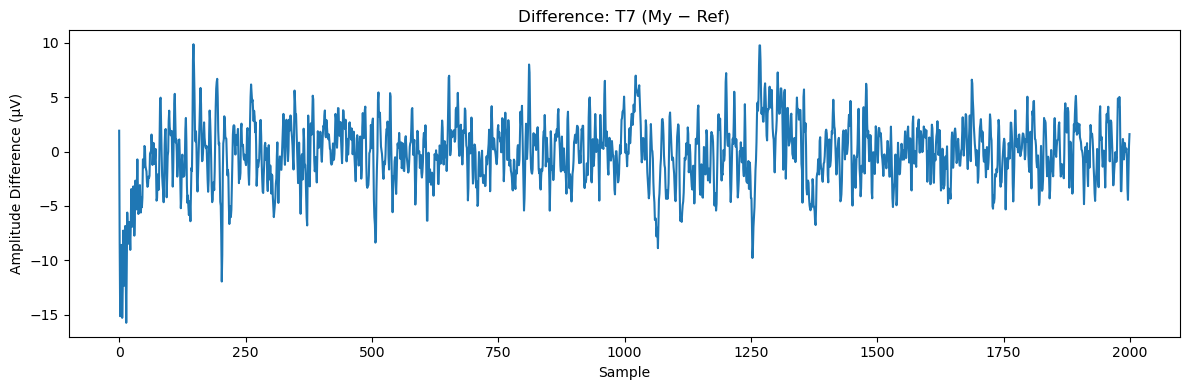

T7 max diff: 15.71953 µV | mean diff: -0.19016 µV
T7 correlation: 0.693456


In [22]:
compare_with_reference(
    eeg_proc,
    reference_file=ref_file,
    channel=0,       # T7
    window=10 * FS,   # 5 seconds
    show_diff=True,
    show_corr=True,
    offset_gap=50
)

The waveform just looks cleaner now compared to the study thus explaining the drop in correlation to the already known signal we are comparing. It is also stated this behavior is [expected](https://www.frontiersin.org/journals/neuroinformatics/articles/10.3389/fninf.2015.00016/full).


Validating the preprocessing pipeline against the PhysioNet filtered signals, EEG data were maintained in the original hardware reference frame. This ensured that waveform morphology and amplitude characteristics were directly comparable between the reconstructed and reference signals. This results in a near .85 correlation. This is a demonstration of replication. 

For downstream analysis, signals were re-referenced to the common average to reduce reference-dependent bias and attenuate global artifacts shared across channels.

A decrease in correlation following average re-referencing was expected, as re-referencing constitutes a linear transformation that alters waveform structure without changing underlying neural information

In [41]:
# --- Comparison plot with overlay for all channels ---
CHANNELS = ['T7', 'F8', 'Cz', 'P4']

def compare_all_channels_overlay(my_eeg):
    """
    Overlay all EEG channels (stacked) comparing custom preprocessing
    vs PhysioNet filtered reference.
    
    Parameters
    ----------
    my_eeg : np.ndarray
        Preprocessed EEG (samples x channels)
    reference_file : str or Path
        Path to PhysioNet Filtered_Data CSV
    """

    n_channels = my_eeg.shape[1]

    # Dynamic vertical offset
    offset = 8 * np.nanstd(my_eeg)

    plt.figure(figsize=(14, 7))

    for ch in range(n_channels):
        y_offset = ch * offset

        plt.plot(
            my_eeg[:, ch] + y_offset,
            color=f"C{ch}",
            label=CHANNELS[ch]
        )

    # Channel labels centered on offsets
    yticks = [ch * offset for ch in range(n_channels)]
    plt.yticks(yticks, CHANNELS)

    # 
    plt.xlabel("Sample")
    plt.ylabel("Amplitude (µV) + offset")
    plt.title("EEG Overlay")

    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


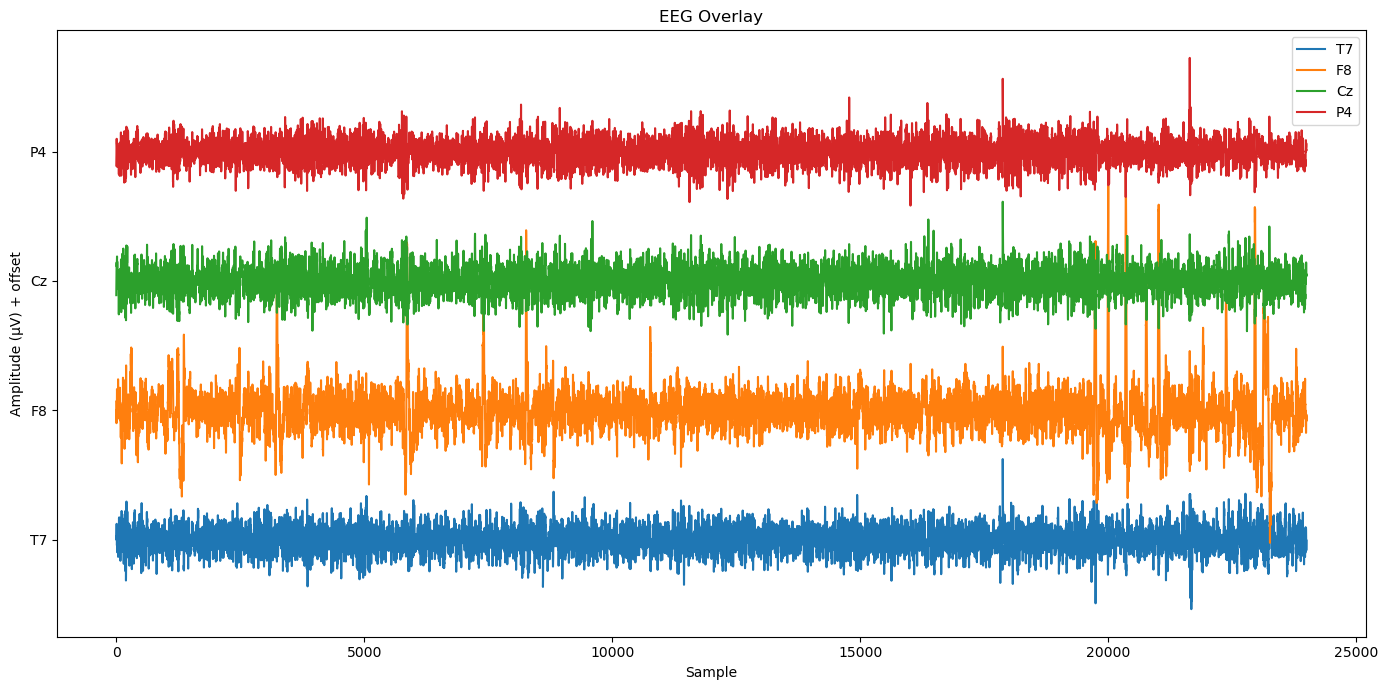

In [42]:
compare_all_channels_overlay(my_eeg=eeg_proc)